# <font color="red"> **_Cyclistic data analysis: Documentation_** </font>
-----------------

In [ ]:
from modin.config import Engine
Engine.put("dask")
from distributed import Client
client = Client(n_workers = 5, threads_per_worker = 2)
import modin.pandas as pd

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import gc
from collections import Counter

In [8]:
os.getcwd()

'D:\\Python\\Capstone'

In [13]:
os.listdir("D:\\Python\\Capstone\\Cyclistic_datasets\\.csv")

# all the comma separated values files transferred to one directory

['202105-divvy-tripdata.csv',
 '202106-divvy-tripdata.csv',
 '202107-divvy-tripdata.csv',
 '202108-divvy-tripdata.csv',
 '202109-divvy-tripdata.csv',
 '202110-divvy-tripdata.csv',
 '202111-divvy-tripdata.csv',
 '202112-divvy-tripdata.csv',
 '202201-divvy-tripdata.csv',
 '202202-divvy-tripdata.csv']

In [18]:
for csv in os.listdir("D:\\Python\\Capstone\\Cyclistic_datasets\\.csv"):
    print(pd.read_csv("Cyclistic_datasets/.csv/" + csv).shape)
    
# all datasets appear to have same number of columns :)

(531633, 13)
(729595, 13)
(822410, 13)
(804352, 13)
(756147, 13)
(631226, 13)
(359978, 13)
(247540, 13)
(103770, 13)
(115609, 13)


In [53]:
df = pd.DataFrame()
for csv in os.listdir("D:\\Python\\Capstone\\Cyclistic_datasets\\.csv"):
    data = pd.read_csv("Cyclistic_datasets/.csv/" + csv)
    df = pd.concat((df, data), axis = 0, ignore_index=True)

# looping over the .csv files and concatenating them into a single large dataset

In [55]:
df.shape

(5102260, 13)

In [56]:
rows = list()
for csv in os.listdir("D:\\Python\\Capstone\\Cyclistic_datasets\\.csv"):
    rows.append(pd.read_csv("Cyclistic_datasets/.csv/" + csv).shape[0])
sum(rows)

5102260

In [57]:
sum(rows) == df.shape[0]  

# voila binding was successful

True

In [59]:
df.to_csv("CyclisticDF.csv")  

# writing the combined dataframe to a .csv file to avoid unnecessary computations in future

In [60]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C809ED75D6160B2A,electric_bike,2021-05-30 11:58:15,2021-05-30 12:10:39,NaN,NaN,NaN,NaN,41.90,-87.63,41.89,-87.61,casual
1,DD59FDCE0ACACAF3,electric_bike,2021-05-30 11:29:14,2021-05-30 12:14:09,NaN,NaN,NaN,NaN,41.88,-87.62,41.79,-87.58,casual
2,0AB83CB88C43EFC2,electric_bike,2021-05-30 14:24:01,2021-05-30 14:25:13,NaN,NaN,NaN,NaN,41.92,-87.70,41.92,-87.70,casual
3,7881AC6D39110C60,electric_bike,2021-05-30 14:25:51,2021-05-30 14:41:04,NaN,NaN,NaN,NaN,41.92,-87.70,41.94,-87.69,casual
4,853FA701B4582BAF,electric_bike,2021-05-30 18:15:39,2021-05-30 18:22:32,NaN,NaN,NaN,NaN,41.94,-87.69,41.94,-87.70,casual


In [72]:
type(df.started_at[1]) # whoopsies a string
(datetime.strptime(df.ended_at[1], "%Y-%m-%d %H:%M:%S") - datetime.strptime(df.started_at[1], "%Y-%m-%d %H:%M:%S"))/60

datetime.timedelta(seconds=44, microseconds=916667)

In [8]:
# not leveraging modin anymore! too many warnings :(
# parsing the date-time columns during data loading instead of doing afterwards

import pandas as pd
regex = lambda date: datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
df = pd.read_csv("D:/Python/Capstone/Cyclistic_datasets/.csv/CyclisticDF.csv", index_col = 0, parse_dates = ["started_at", "ended_at"], date_parser = regex)

In [17]:
# duration of the ride

ride_length = pd.Series(df.ended_at - df.started_at)

In [5]:
# weekday() enumerates weekdays from 0 to 6 for monday to sunday
# isoweekday() enumerates weekdays from 1 to 7 for monday to sunday
# dtype is specified to integer since the column is required to be free of decimals

day_of_week = pd.Series([time.isoweekday() for time in df.started_at], dtype = int)

In [54]:
df["ride_length"] = ride_length
df["day_of_week"] = day_of_week

In [ ]:
# overwriting the previous .csv file with the new dataframe that has 2 additional columns

df.to_csv("D:/Python/Capstone/Cyclistic_datasets/.csv/CyclisticDF.csv")

In [18]:
# an array of ride durations in minutes

duration_mins = np.array([T.total_seconds() for T in ride_length], dtype = float) / 60

In [19]:
min(df.ride_length), max(df.ride_length)

# how come there are negative values in duration?

('-1 days +23:01:58', '9 days 22:56:12')

In [21]:
duration_mins[np.where(duration_mins < 0)]  # welp :(
len(duration_mins[np.where(duration_mins < 0)])  # 138 negatives

138

In [86]:
# it doesn't look like negatives are caused by string parsing ignoring dates and considering just the time!

s = datetime.strptime("2012-03-22 11:30:45", "%Y-%m-%d %H:%M:%S")
e = datetime.strptime("2012-03-23 12:30:45", "%Y-%m-%d %H:%M:%S")

(e - s).total_seconds()/3600  # perfect

25.0

In [22]:
neg_indx = np.where(duration_mins < 0)[0]

In [23]:
# wtf
# this might be possible if the time markers at the places where the bicycle is taken and returned are not in sync

pd.DataFrame([df.started_at[neg_indx], df.ended_at[neg_indx]])

,313131,398492,546975,600993,781002,1103542,1260494,1333346,1333537,1334084,...,4597836,4612184,4612965,4614784,4618451,4621433,4630524,4632495,4633942,4635312
started_at,2021-05-05 16:10:04,2021-05-20 12:31:53,2021-06-20 10:52:26,2021-06-15 20:58:03,2021-06-02 17:52:32,2021-06-28 13:18:26,2021-06-28 14:56:28,2021-07-23 11:32:12,2021-07-21 08:02:07,2021-07-27 19:11:55,...,2021-11-07 01:37:57,2021-11-07 01:42:19,2021-11-07 01:52:22,2021-11-07 01:26:28,2021-11-07 01:19:04,2021-11-07 01:49:11,2021-11-07 01:31:33,2021-11-07 01:59:53,2021-11-07 01:57:53,2021-11-07 01:53:34
ended_at,2021-05-05 16:09:51,2021-05-20 12:31:52,2021-06-20 10:52:25,2021-06-15 20:54:51,2021-06-02 17:47:26,2021-06-28 13:18:25,2021-06-28 14:56:27,2021-07-23 11:32:08,2021-07-21 08:02:02,2021-07-27 19:11:54,...,2021-11-07 01:13:17,2021-11-07 01:03:58,2021-11-07 01:01:29,2021-11-07 01:08:35,2021-11-07 01:00:27,2021-11-07 01:13:26,2021-11-07 01:03:44,2021-11-07 01:09:02,2021-11-07 01:27:02,2021-11-07 01:00:42


---------------------------------------
### <font color ="red"> **_The bikes can be unlocked from one station and returned to any other station in the system anytime._** - _text instruction. So may be... may be......_ </font>        
### _But how the hell times at different stations can vary by 30 to 50 minutes? Were the "clocks" malfunctioning?_
__________________________________

In [24]:
# have to remove these records

df.loc[neg_indx,:]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week
313131,3EC1B5A4D4B9AB99,classic_bike,2021-05-05 16:10:04,2021-05-05 16:09:51,Dayton St & North Ave,13058,Dayton St & North Ave,13058,41.910578,-87.649422,41.910578,-87.649422,member,-1 days +23:59:47,3
398492,518535DDFA372694,electric_bike,2021-05-20 12:31:53,2021-05-20 12:31:52,NaN,NaN,Ellis Ave & 60th St,KA1503000014,41.790000,-87.600000,41.785068,-87.601077,member,-1 days +23:59:59,4
546975,732D84DAD2CC9B73,classic_bike,2021-06-20 10:52:26,2021-06-20 10:52:25,Clinton St & Polk St,15542,Clinton St & Polk St,15542,41.871467,-87.640949,41.871467,-87.640949,casual,-1 days +23:59:59,7
600993,A18D39992AA99793,classic_bike,2021-06-15 20:58:03,2021-06-15 20:54:51,Broadway & Sheridan Rd,13323,Broadway & Sheridan Rd,13323,41.952833,-87.649993,41.952833,-87.649993,casual,-1 days +23:56:48,2
781002,126E4DA0FA0A3E11,electric_bike,2021-06-02 17:52:32,2021-06-02 17:47:26,NaN,NaN,Southport Ave & Wrightwood Ave,TA1307000113,41.930000,-87.660000,41.928752,-87.663932,member,-1 days +23:54:54,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621433,287605D0D79731E6,electric_bike,2021-11-07 01:49:11,2021-11-07 01:13:26,NaN,NaN,NaN,NaN,41.930000,-87.650000,41.970000,-87.700000,casual,-1 days +23:24:15,7
4630524,8598DCE30427F984,electric_bike,2021-11-07 01:31:33,2021-11-07 01:03:44,Orleans St & Elm St,TA1306000006,NaN,NaN,41.902921,-87.637709,41.930000,-87.660000,casual,-1 days +23:32:11,7
4632495,5AA2BC364BC7A569,electric_bike,2021-11-07 01:59:53,2021-11-07 01:09:02,NaN,NaN,NaN,NaN,41.920000,-87.690000,41.900000,-87.700000,casual,-1 days +23:09:09,7
4633942,F4E4485BFB33D916,electric_bike,2021-11-07 01:57:53,2021-11-07 01:27:02,NaN,NaN,NaN,NaN,41.910000,-87.720000,41.900000,-87.770000,casual,-1 days +23:29:09,7


In [41]:
troublesome = Counter(df.loc[neg_indx,:].day_of_week)
troublesome

# most faulty time records seem to have happened on Sundays!!

Counter({3: 36, 4: 4, 7: 64, 2: 7, 1: 10, 5: 8, 6: 9})

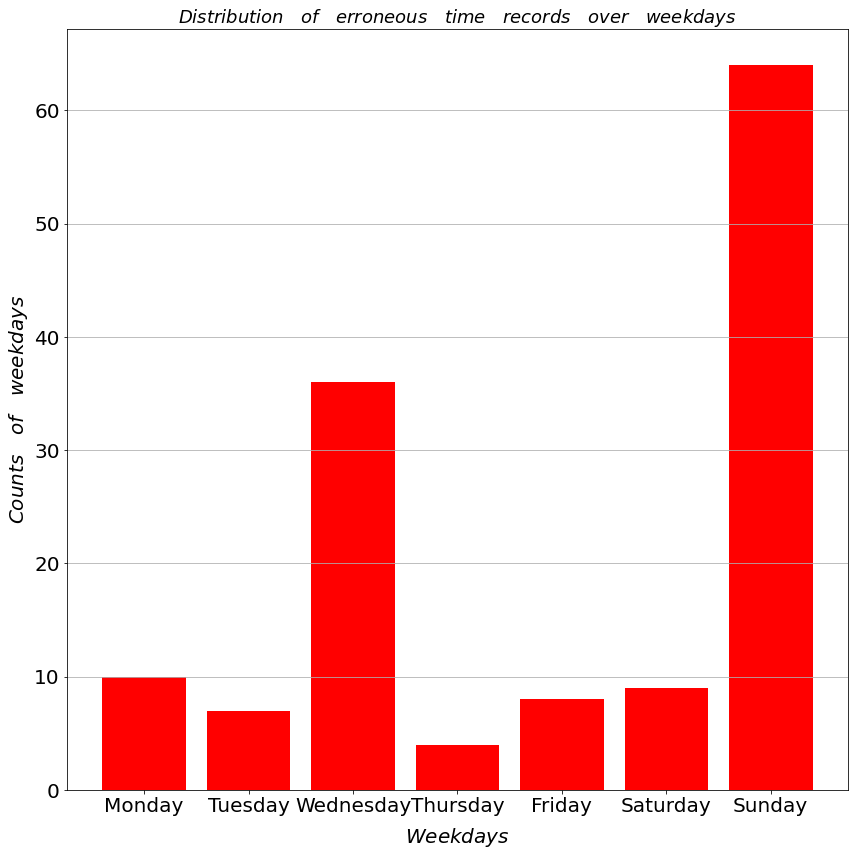

In [60]:
plt.figure(figsize = (14,14))
plt.bar(troublesome.keys(), height= troublesome.values(), align="center", color = "red")
plt.rcParams["font.size"] = 15
plt.ylabel("$Counts\hspace{1}of\hspace{1}weekdays$")
plt.xlabel("$Weekdays$", labelpad=10)
plt.grid(axis="y")
plt.xticks(ticks = range(1,8), labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("$Distribution\hspace{1}of\hspace{1}erroneous\hspace{1}time\hspace{1}records\hspace{1}over\hspace{1}weekdays$")
plt.show()

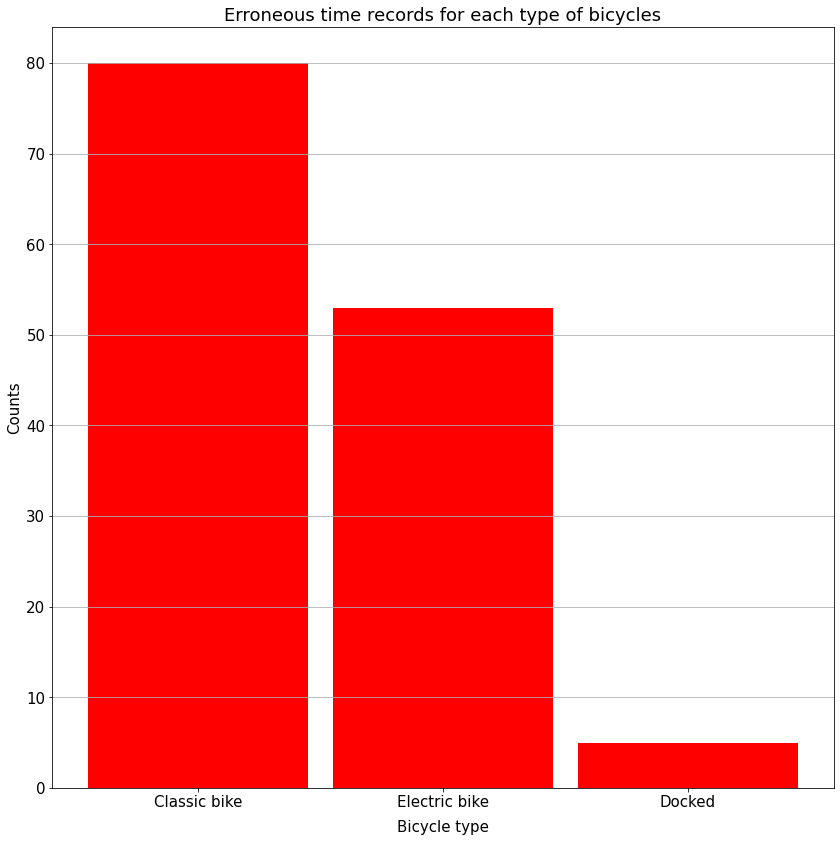

In [90]:
erroneous = df.loc[neg_indx,:]
plt.figure(figsize = (14,14))
plt.hist(erroneous.rideable_type, bins=np.arange(0.5,4.5,1, dtype=int), rwidth=0.9, color = "red")
plt.grid(axis="y")
plt.xlabel("Bicycle type", labelpad=10)
plt.ylabel("Counts")
plt.xticks(ticks=[0.5,1.5,2.5], labels=["Classic bike","Electric bike","Docked"])
plt.title("Erroneous time records for each type of bicycles")
plt.show()

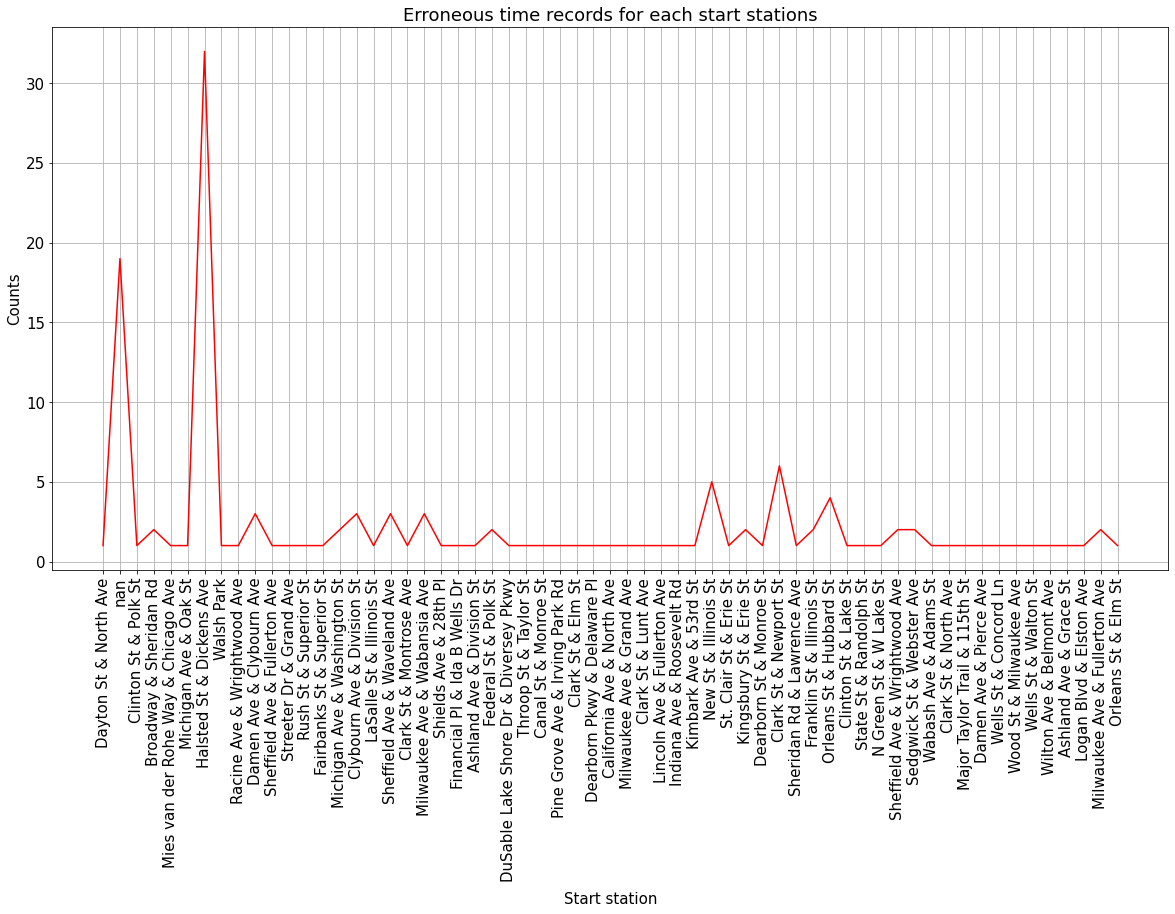

In [114]:
erroneous = df.loc[neg_indx,:]
plt.figure(figsize = (20,10))
plt.rcParams["font.size"] = 15
plt.plot(Counter(erroneous.start_station_name).keys(), Counter(erroneous.start_station_name).values(), color = "red")
plt.grid(axis="both")
plt.xlabel("Start station", labelpad=10)
plt.xticks(rotation = "vertical")
plt.ylabel("Counts")
plt.title("Erroneous time records for each start stations")
plt.show()


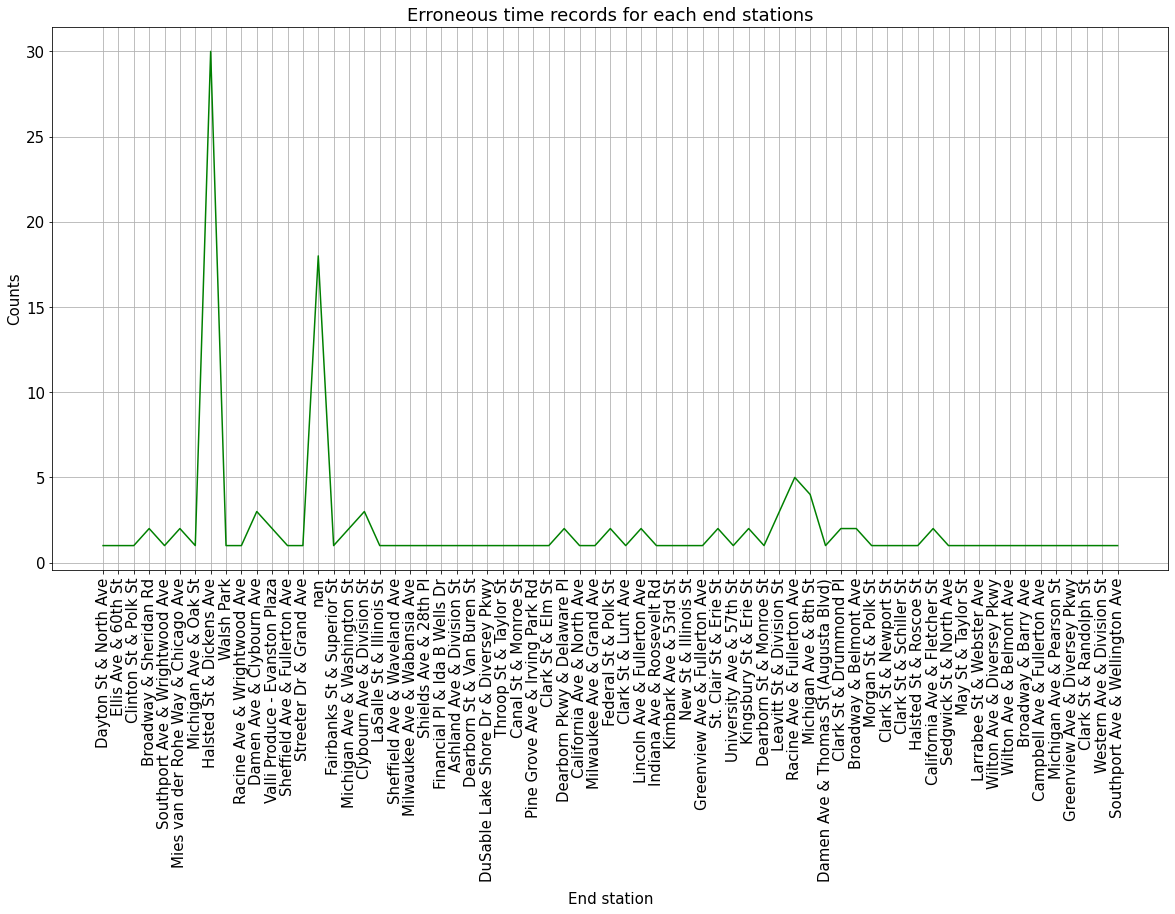

In [115]:
plt.figure(figsize = (20,10))
plt.rcParams["font.size"] = 15
plt.plot(Counter(erroneous.end_station_name).keys(), Counter(erroneous.end_station_name).values(), color = "green")
plt.grid(axis="both")
plt.xlabel("End station", labelpad=10)
plt.xticks(rotation = "vertical")
plt.ylabel("Counts")
plt.title("Erroneous time records for each end stations")
plt.show()

###  **Through above plots it becomes apparent that most of the erroneous time marks have happened at <font color = "red"> _Halsted Street & Dickens Avenue_ </font> station, thus the timers there must be malfunctioning!** 

In [89]:
df.drop(neg_indx, axis = 0).shape[0] == df.shape[0] - 138

# good to go

True

In [116]:
data = df.drop(neg_indx, axis = 0)

In [117]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week
0,C809ED75D6160B2A,electric_bike,2021-05-30 11:58:15,2021-05-30 12:10:39,NaN,NaN,NaN,NaN,41.90,-87.63,41.89,-87.61,casual,0 days 00:12:24,7
1,DD59FDCE0ACACAF3,electric_bike,2021-05-30 11:29:14,2021-05-30 12:14:09,NaN,NaN,NaN,NaN,41.88,-87.62,41.79,-87.58,casual,0 days 00:44:55,7
2,0AB83CB88C43EFC2,electric_bike,2021-05-30 14:24:01,2021-05-30 14:25:13,NaN,NaN,NaN,NaN,41.92,-87.70,41.92,-87.70,casual,0 days 00:01:12,7
3,7881AC6D39110C60,electric_bike,2021-05-30 14:25:51,2021-05-30 14:41:04,NaN,NaN,NaN,NaN,41.92,-87.70,41.94,-87.69,casual,0 days 00:15:13,7
4,853FA701B4582BAF,electric_bike,2021-05-30 18:15:39,2021-05-30 18:22:32,NaN,NaN,NaN,NaN,41.94,-87.69,41.94,-87.70,casual,0 days 00:06:53,7


# <font color="red"> **_Descriptive analysis_** </font>
___________________________

In [118]:
Counter(data.day_of_week)

Counter({7: 781522,
         3: 698460,
         2: 669681,
         1: 644762,
         6: 892321,
         4: 684361,
         5: 731015})

In [119]:
# counting the frequency of bicycle rentals for each weekday
days = Counter(data.day_of_week).keys()
freq = Counter(data.day_of_week).values()

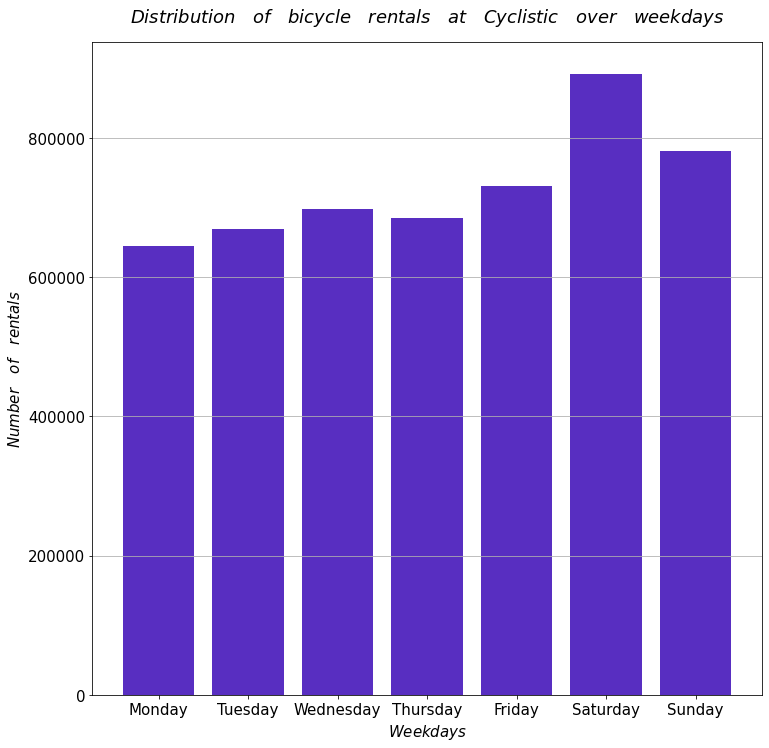

In [120]:
# distribution of bicycle rentals over weekdays

plt.figure(figsize = (12,12))
plt.rcParams["font.size"] = 15
plt.title("$Distribution\hspace{1}of\hspace{1}bicycle\hspace{1}rentals\hspace{1}at\hspace{1}Cyclistic\hspace{1}over\hspace{1}weekdays$", pad = 20)
plt.grid(axis="y", which="both")
plt.bar(x = days, height = freq, color = "#582EC1")
plt.xlabel("$Weekdays$", labelpad=5)
plt.xticks(ticks=range(1,8) , labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel("$Number\hspace{1}of\hspace{1}rentals$", labelpad=5)
plt.show()

In [180]:
df.member_casual.unique()

array(['casual', 'member'], dtype=object)

In [123]:
member = data[data.member_casual == "member"]
member_ride_length = pd.Series([time.total_seconds() for time in (member.ended_at - member.started_at)])
casual = data[data.member_casual == "casual"]
casual_ride_length = pd.Series([time.total_seconds() for time in (casual.ended_at - casual.started_at)])

In [125]:
member["ride_length"] = member_ride_length
casual["ride_length"] = casual_ride_length

C:\Users\Anoba\AppData\Local\Temp\ipykernel_9992\1415821391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  member["ride_length"] = member_ride_length
C:\Users\Anoba\AppData\Local\Temp\ipykernel_9992\1415821391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casual["ride_length"] = casual_ride_length


In [158]:
type(member.ride_length[89])
np.mean(member.ride_length)
np.median(member.ride_length, )

nan

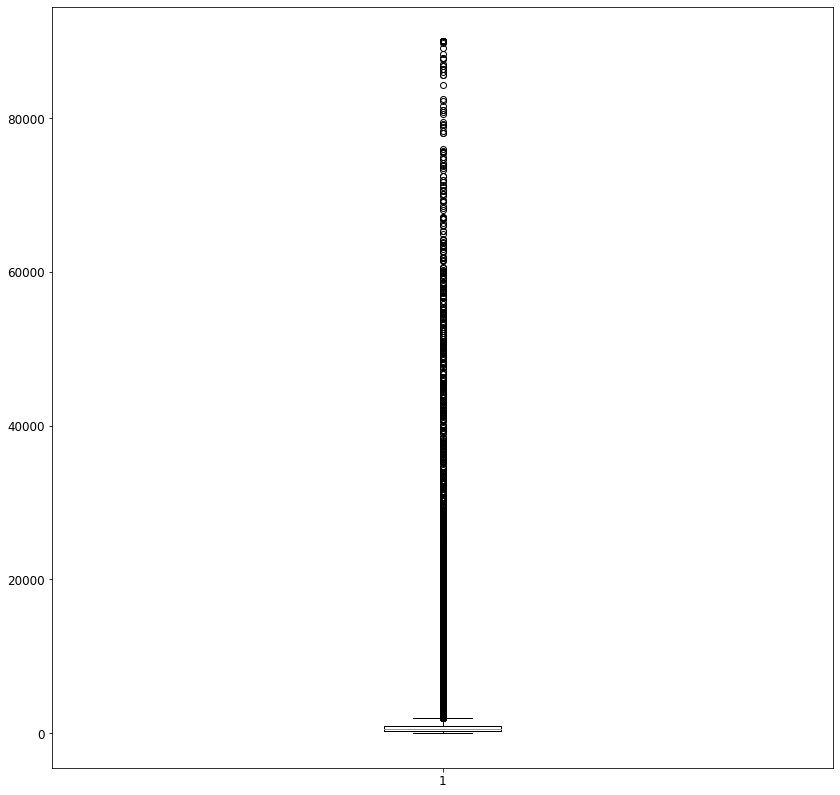

In [156]:
plt.figure(figsize=(14,14))
plt.boxplot(member.ride_length[np.logical_not(np.isnan(member.ride_length))])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x21b40d190a0>,
 'caps': [<matplotlib.lines.Line2D at 0x21b40d19610>,
 'boxes': [<matplotlib.lines.Line2D at 0x21b40d10e20>],
 'medians': [<matplotlib.lines.Line2D at 0x21b40d19bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x21b40d19e80>],
 'means': []}

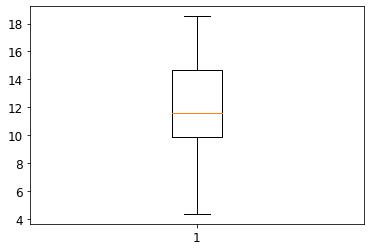

In [154]:
plt.boxplot(np.random.normal(12,3,100))